In [ ]:
import os

In [ ]:
base_dir ='/content/drive/MyDrive/Colab Notebooks/Data Analytics codes/Analyzing fire images DA project Fall 20 /Dataset/Training/'
validation_dir ='/content/drive/MyDrive/Colab Notebooks/Data Analytics codes/Analyzing fire images DA project Fall 20 /Dataset/Validation/'
fire_dir =base_dir +'Fire/'
non_fire_dir =base_dir +'Non Fire/'

In [ ]:
fire_fnames = os.listdir(fire_dir)
print(fire_fnames[:10])
non_fire_fnames = os.listdir(non_fire_dir)
print(non_fire_fnames[:10])

['368.jpg', '327.jpg', '435.jpg', '390.jpg', '456.jpg', '393.jpg', '381.jpg', '354.jpg', '453.jpg', '470.jpg']
['634.jpg', '119.jpg', '560.jpg', '945.jpg', '162.jpg', '500.jpg', '1186.jpg', '496.jpg', '707.jpg', '946.jpg']


In [ ]:
print('total fire images:', len(os.listdir(fire_dir)))
print('total non fire images:', len(os.listdir(non_fire_dir)))

total fire images: 1268
total non fire images: 488


In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

Image_dimensions = (240,240,3)

# Index for iterating over images
pic_index = 0

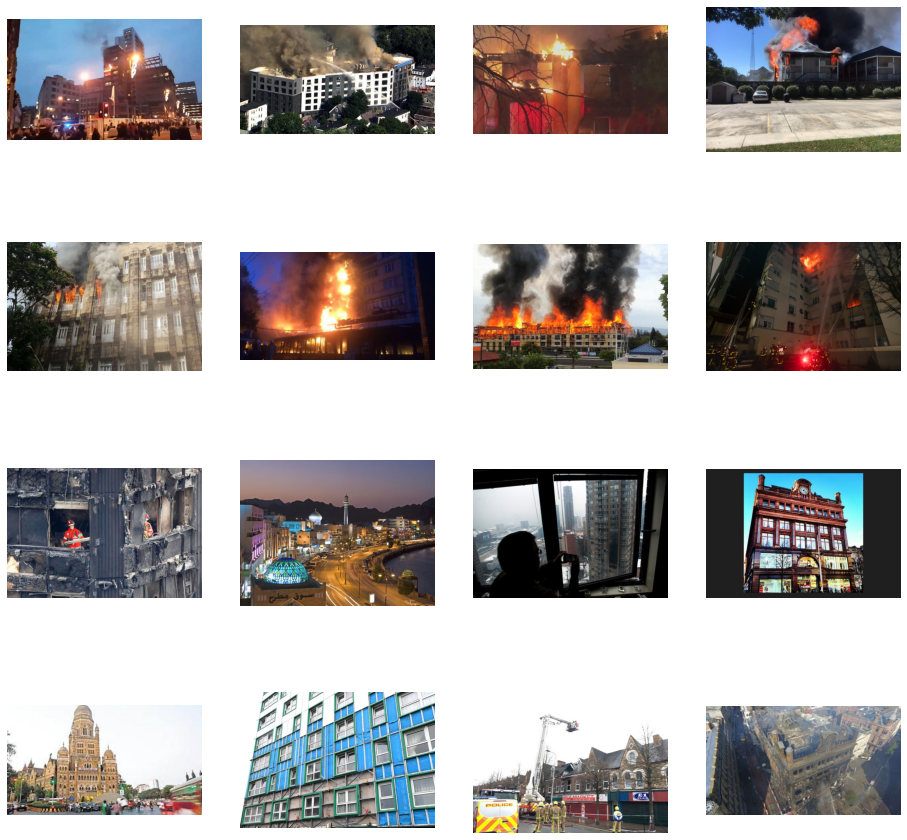

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_fire_pix = [os.path.join(fire_dir, fname) 
                for fname in fire_fnames[pic_index-8:pic_index]]
next_non_fire_pix = [os.path.join(non_fire_dir , fname) 
                for fname in non_fire_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_fire_pix+next_non_fire_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path,0)
  plt.imshow(img)

plt.show()

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
# Our input feature map is 240x240x3: 240x240 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=Image_dimensions)

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 238, 238, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 119, 119, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 117, 117, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 58, 58, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)       

In [ ]:
import tensorflow
from tensorflow.keras.optimizers import RMSprop

initial_learning_rate = 0.001
lr_schedule = tensorflow.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10,
    decay_rate=0.96,
    staircase=True)

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=lr_schedule),
              metrics=['acc'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
 
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range = 30, zoom_range = 0.20, 
fill_mode = "nearest", shear_range = 0.20, horizontal_flip = True, 
width_shift_range = 0.1, height_shift_range = 0.1)
 
val_datagen = ImageDataGenerator(rescale=1./255)
 
 
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        base_dir,  # This is the source directory for training images
        target_size=(Image_dimensions[0], Image_dimensions[1]),  # All images will be resized to 
        batch_size=100,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')
 
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(Image_dimensions[0], Image_dimensions[1]),
        batch_size=100,
        class_mode='binary')

Found 1756 images belonging to 2 classes.
Found 439 images belonging to 2 classes.


In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch= 17,  # 1756  images / batch_size (100) = steps (17)
      epochs=50,
      validation_data=validation_generator,
      validation_steps= 4,  # 439  images / batch_size (100) = steps (4)
      verbose=1)

Epoch 1/50
17/17 [==============================] - ETA: 0s - loss: 1.1085 - acc: 0.6576

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


17/17 [==============================] - 79s 5s/step - loss: 1.1085 - acc: 0.6576 - val_loss: 0.3165 - val_acc: 0.9050
Epoch 2/50
17/17 [==============================] - 75s 4s/step - loss: 0.4361 - acc: 0.7929 - val_loss: 0.4297 - val_acc: 0.8400
Epoch 3/50
17/17 [==============================] - 76s 4s/step - loss: 0.4064 - acc: 0.8043 - val_loss: 0.2842 - val_acc: 0.9025
Epoch 4/50
17/17 [==============================] - 74s 4s/step - loss: 0.4110 - acc: 0.8007 - val_loss: 0.2228 - val_acc: 0.9375
Epoch 5/50
17/17 [==============================] - 77s 5s/step - loss: 0.3528 - acc: 0.8490 - val_loss: 0.1850 - val_acc: 0.9325
Epoch 6/50
17/17 [==============================] - 75s 4s/step - loss: 0.3303 - acc: 0.8575 - val_loss: 0.1974 - val_acc: 0.9400
Epoch 7/50
17/17 [==============================] - 75s 4s/step - loss: 0.3200 - acc: 0.8690 - val_loss: 0.1969 - val_acc: 0.9325
Epoch 8/50
17/17 [==============================] - 75s 4s/step - loss: 0.2880 - acc: 0.8786 - val_lo

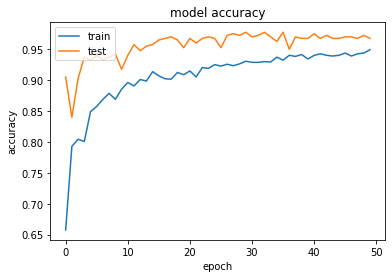

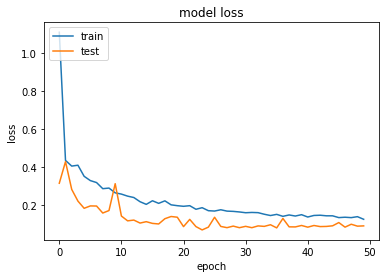

In [ ]:
# Plotting history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plotting history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()